In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
import GP_class
import george
import numpy.random as rnd
import corner

import sys
import time as tm
import multiprocessing as mp

### NOTE TO SELF ###

# When testing the speed of the prior sampling (numpy vs scipy), numpy took ~32 ms for 10**6 samples 
# while scipy took 386 microseconds (so negligable) to set up the distribution and 23 ms to create the 10**6 samples.
# For 10**8 samples, numpy took 3.03 seconds while scipy took 2.35 seconds. So I'll be sticking with scipy for now.

# numpy code
#%timeit J_log_period = np.random.normal(size=100000000)*0.5 + np.log(4/24.) 

# scipy code
#nsamples = 100000000
#%timeit prior_log_period = scipy.stats.norm(np.log(4./24.), (12./24.))
#%timeit J_log_period_2= prior_log_period.rvs(nsamples)

In [60]:
def read_data(filename, whitespace=False, datadir="./"):
    """
    Read in light curve data from asteroid.
    """

    data  = pd.read_csv(datadir+filename, header=None, delim_whitespace=whitespace)

    tsample = data[0]
    fsample = data[1]
    flux_err = data[2]

    return tsample, fsample, flux_err
filename = "../data/simulation_results_new/3200/3200_lc_49627_to_49787.txt_sampled_ztf-lsst_60days.txt"
time, flux, flux_err = read_data("../data/simulation_results_new/3200/3200_lc_49627_to_49787.txt_sampled_ztf-lsst_60days.txt")

In [8]:
# 1 : set up the prior distriubtion
prior_mean = scipy.stats.norm(1, 0.5)
prior_log_amp = scipy.stats.norm(np.log(0.15), np.log(2))
prior_log_gamma = scipy.stats.norm(np.log(10), np.log(2))
prior_log_period = scipy.stats.norm(np.log(4./24.), (12./24.))

In [22]:
nsamples = 10**6

J_mean = prior_mean.rvs(nsamples)
J_log_amp = prior_log_amp.rvs(nsamples)
J_log_gamma = prior_log_gamma.rvs(nsamples)
J_log_period= prior_log_period.rvs(nsamples)

In [23]:
kernel = np.exp(0) * george.kernels.ExpSine2Kernel(gamma = 1, log_period = 0)
gp = george.GP(kernel, fit_mean=True, mean=1)
gp.compute(time, flux_err)

In [24]:
class DataManager:
    def __init__(self, time, flux, flux_err):
        self.flux = flux
        kernel = np.exp(0) * george.kernels.ExpSine2Kernel(gamma = 1, log_period = 0)
        self.gp = george.GP(kernel, fit_mean=True, mean=1)
        self.gp.compute(time, flux_err)

    def calculate_likelihood(self, params):
        self.gp.set_parameter_vector(params)

        try:
            #gp.compute(time, flux_err)
            lnlike = self.gp.log_likelihood(self.flux)
        except np.linalg.LinAlgError:
            lnlike = -1e25

        return lnlike

In [25]:
import multiprocessing as mp
(mp.cpu_count())

8

In [26]:
# Parallelizing using Pool.map()
manager = DataManager(time, flux, flux_err)

start_time = tm.time()


pool = mp.Pool(7)

L_results = []
L_results = pool.map(manager.calculate_likelihood, zip(J_mean, J_log_amp, np.exp(J_log_gamma), J_log_period))
L_results = np.array(L_results)
pool.close()

end_time = tm.time()
print("\ntotal time taken for this loop: %.2f seconds" %(end_time - start_time))


total time taken for this loop: 208.62 seconds


In [28]:
# 3 : Pick a random number r out of a uniform distribution between 0 and Lmax
uu = rnd.uniform(size=len(L_results))

good_samples_bool = 0.01 < np.exp(L_results-max(L_results))
good_samples_idx, = np.where(good_samples_bool)

len(good_samples_idx)

2


total time taken plotting : 1.26 seconds


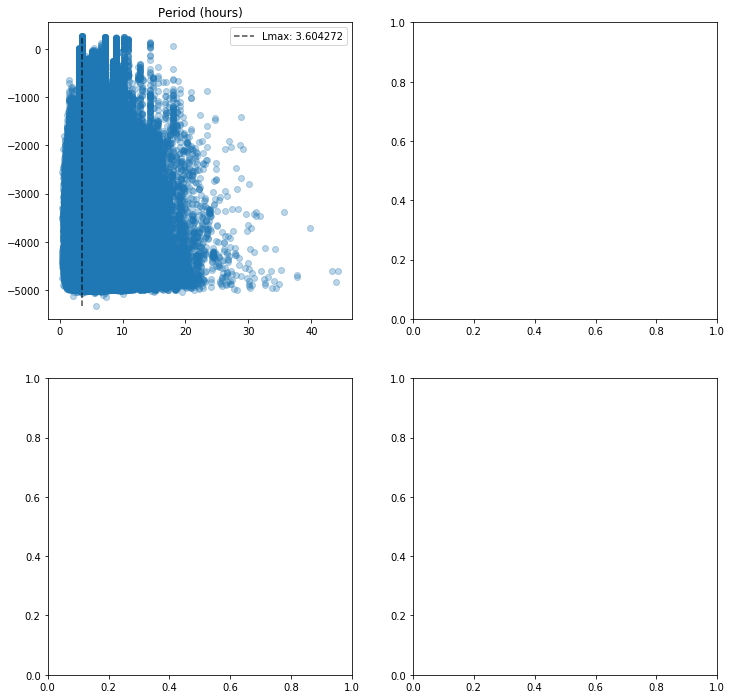

In [37]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
start_time = tm.time()
ax[0,0].scatter(np.exp(J_log_period)*24., L_results, alpha = 0.3)

L_max_period = np.exp(J_log_period[np.where(L_results==L_results.max())])*24.
ax[0,0].vlines(L_max_period, L_results.min(), L_results.max(), label="Lmax: %f" %L_max_period, linestyles='dashed', alpha=0.7)
ax[0,0].legend()
ax[0,0].set_title("Period (hours)")

end_time = tm.time()
print("\ntotal time taken plotting : %.2f seconds" %(end_time - start_time))
#ax[0,1].scatter(J_mean, L_results)

#L_max_mean = J_mean[np.where(L_results==L_results.max())]
#ax[0,1].vlines(L_max_mean, L_results.min(), L_results.max(), label="Lmax: %f" %L_max_mean, linestyles='dashed', alpha=0.7)
#ax[0,1].legend()
#ax[0,1].set_title("Mean")


#ax[1,0].scatter(J_log_amp, L_results)

#L_max_amp = np.exp(J_log_amp[np.where(L_results==L_results.max())])
#ax[1,0].vlines(L_max_amp, L_results.min(), L_results.max(), label="Lmax: %f" %L_max_amp, linestyles='dashed', alpha=0.7)
#ax[1,0].legend()
#ax[1,0].set_title("Amplitude")

#ax[1,1].scatter(np.exp(J_log_gamma), L_results)

#L_max_gamma = np.exp(J_log_gamma[np.where(L_results==L_results.max())])
#ax[1,1].vlines(L_max_gamma, L_results.min(), L_results.max(), label="Lmax: %f" %L_max_gamma, linestyles='dashed', alpha=0.7)
#ax[1,1].legend()
#ax[1,1].set_title("Gamma")


total time taken plotting : 0.90 seconds


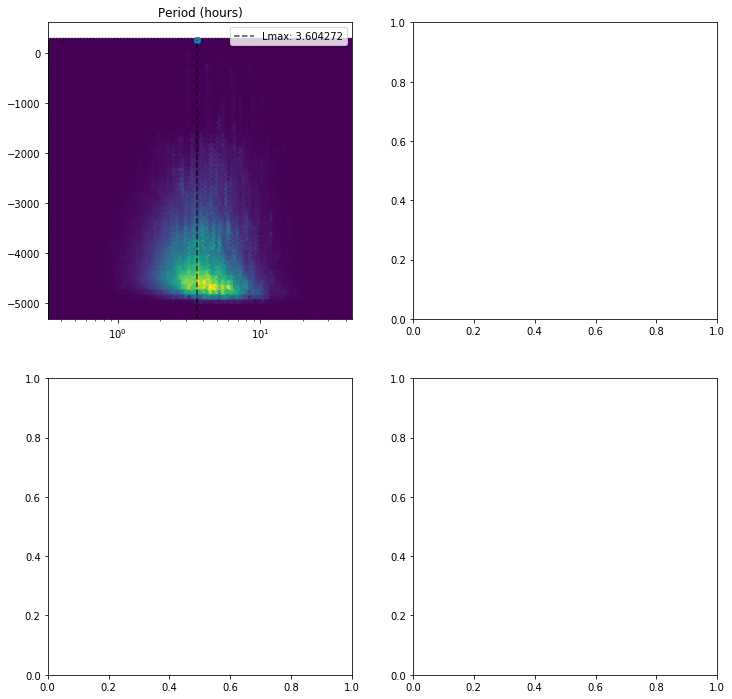

In [46]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
start_time = tm.time()
ax[0,0].hexbin(np.exp(J_log_period)*24., L_results, xscale='log')
ax[0,0].scatter(np.exp(J_log_period[good_samples_idx])*24., L_results[good_samples_idx])
L_max_period = np.exp(J_log_period[np.where(L_results==L_results.max())])*24.
ax[0,0].vlines(L_max_period, L_results.min(), L_results.max(), label="Lmax: %f" %L_max_period, linestyles='dashed', alpha=0.7)
ax[0,0].legend()
ax[0,0].set_title("Period (hours)")

end_time = tm.time()
print("\ntotal time taken plotting : %.2f seconds" %(end_time - start_time))

In [56]:
import plotting
plotting.plot_folded_lightcurve(time, flux, L_max_period, flux_err=None,
                              models=None,#[t_pred, m_all],
                              true_lightcurve=None, ax=ax, use_radians=False)

AttributeError: 'numpy.ndarray' object has no attribute 'scatter'

/home/christina/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


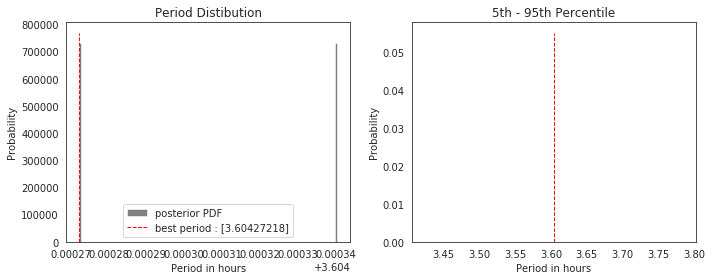

In [64]:
### plot histogram of periods ###
true_period = L_max_period
fig, (ax, bx) = plt.subplots(1, 2, figsize=(10,4))
p_hours = np.exp(J_log_period[good_samples_idx])*24.
ax.hist(p_hours, bins=100, density=True,
            label="posterior PDF", color="black", alpha=0.5)

if true_period is not None:
    ylim = ax.get_ylim()
    ax.vlines(true_period, 0, ylim[-1], lw=1, color="red", linestyle="dashed", label="best period : " + str(true_period))

ax.set_xlabel("Period in hours")
ax.set_ylabel("Probability")
ax.set_title("Period Distibution")
ax.legend()

lower, upper = np.percentile(p_hours, [5,95])
bx.hist(p_hours[(p_hours > lower) & (p_hours < upper)], bins=100, density=True,
            label="posterior PDF", color="black", alpha=0.5)
bx.set_title("5th - 95th Percentile")
bx.set_xlabel("Period in hours")
bx.set_ylabel("Probability")

if true_period is not None:
    ylim = bx.get_ylim()
    bx.vlines(true_period, 0, ylim[-1], lw=1, color="red", linestyle="dashed", label="best period : " + str(true_period))


plt.tight_layout()
plt.savefig(filename + "rej_sampler_period_pdf.pdf", format="pdf")

In [61]:
data = np.array([np.exp(J_log_period[good_samples_idx])*24, np.exp(J_log_gamma[good_samples_idx]), np.exp(J_log_amp[good_samples_idx]), J_mean[good_samples_idx]]).T
figure = corner.corner(data, labels=["period", 'gamma', 'amp', 'mean'])#, J_log_gamma[good_samples_idx], J_mean[good_samples_idx])
plt.savefig("posterior_corner.pdf", format="pdf")

AssertionError: I don't believe that you want more dimensions than samples!

In [49]:
L_max_period = np.exp(J_log_period[np.where(L_results==max(L_results))])*24.
L_max_period

array([3.60427218])

In [ ]:
plt.scatter(np.exp(J_log_period)*24., np.exp(L_results-max(L_results)))

# plot l_max
L_max_period = np.exp(J_log_period[np.where(L_results==max(L_results))])*24.
plt.vlines(L_max_period, 0, 1, label="Lmax: %f" %L_max_period, linestyles='dashed', alpha=0.7)
plt.legend()

In [ ]:
plt.scatter(J_mean, np.exp(L_results-L_results.max()))

# plot l_max
L_max_mean = J_mean[np.where(L_results==L_results.max())]
plt.vlines(L_max_mean, 0, 1, label="Lmax: %f" %L_max_period, linestyles='dashed', alpha=0.7)
plt.legend()

In [ ]:
len(good_samples_idx)

In [ ]:
import plotting

In [2]:
good_ind = [1,2,3]
len(good_ind)

3

In [5]:
data print("hello %s" %len(good_ind))

hello 3


In [ ]:
plotting.plot_folded_lightcurve(time, flux, period = np.exp(J_log_period[np.where(L_results==L_results.max())]))

In [ ]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

In [ ]:
import numpy as np
from time import time

# Prepare data
np.random.RandomState(100)
arr = np.random.randint(0, 10, size=[200000, 5])
data = arr.tolist()
data[:5]

In [ ]:
# Solution Without Paralleization

def howmany_within_range(row, minimum, maximum):
    """Returns how many numbers lie within `maximum` and `minimum` in a given `row`"""
    count = 0
    for n in row:
        if minimum <= n <= maximum:
            count = count + 1
    return count

results = []
for row in data:
    results.append(howmany_within_range(row, minimum=4, maximum=8))

print(results[:10])
#> [3, 1, 4, 4, 4, 2, 1, 1, 3, 3]

In [ ]:
# Parallelizing using Pool.apply()

import multiprocessing as mp

# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# Step 2: `pool.apply` the `howmany_within_range()`
results = [pool.apply(howmany_within_range, args=(row, 4, 8)) for row in data]

# Step 3: Don't forget to close
pool.close()    

print(results[:10])
#> [3, 1, 4, 4, 4, 2, 1, 1, 3, 3]

In [ ]:
# Parallelizing using Pool.map()
import multiprocessing as mp

# Redefine, with only 1 mandatory argument.
def howmany_within_range_rowonly(row, minimum=4, maximum=8):
    count = 0
    for n in row:
        if minimum <= n <= maximum:
            count = count + 1
    return count

pool = mp.Pool(mp.cpu_count())

results = pool.map(howmany_within_range_rowonly, [row for row in data])

pool.close()

print(results[:10])
#> [3, 1, 4, 4, 4, 2, 1, 1, 3, 3]